In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fft import fft
from scipy.stats import skew, entropy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report
from sklearn.svm import OneClassSVM
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import shap

In [2]:
# Load CMAPSS Dataset
cmapss_dir = "../data/raw/CMAPSS/"
train_file = os.path.join(cmapss_dir, "train_FD001.txt")
test_file = os.path.join(cmapss_dir, "test_FD001.txt")
rul_file = os.path.join(cmapss_dir, "RUL_FD001.txt")

# Column names based on CMAPSS documentation
col_names = ['unit_number', 'time_in_cycles',
             'operational_setting_1', 'operational_setting_2', 'operational_setting_3'] + \
            [f'sensor_{i}' for i in range(1, 22)]

train_FD001 = pd.read_csv(train_file, sep=" ", header=None)
train_FD001 = train_FD001.dropna(axis=1, how='all')  # remove empty columns
train_FD001.columns = col_names

print("CMAPSS Training Data (FD001):")
print(train_FD001.head())

CMAPSS Training Data (FD001):
   unit_number  time_in_cycles  operational_setting_1  operational_setting_2  \
0            1               1                -0.0007                -0.0004   
1            1               2                 0.0019                -0.0003   
2            1               3                -0.0043                 0.0003   
3            1               4                 0.0007                 0.0000   
4            1               5                -0.0019                -0.0002   

   operational_setting_3  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
0                  100.0    518.67    641.82   1589.70   1400.60     14.62   
1                  100.0    518.67    642.15   1591.82   1403.14     14.62   
2                  100.0    518.67    642.35   1587.99   1404.20     14.62   
3                  100.0    518.67    642.35   1582.79   1401.87     14.62   
4                  100.0    518.67    642.37   1582.85   1406.22     14.62   

   ...  sensor_12  s

In [3]:
# Generate uncapped RUL for training data
max_cycles = train_FD001.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycle']
train_FD001 = train_FD001.merge(max_cycles, on='unit_number', how='left')
train_FD001['RUL'] = train_FD001['max_cycle'] - train_FD001['time_in_cycles']
train_FD001.drop(columns=['max_cycle'], inplace=True)

print(train_FD001[['unit_number', 'time_in_cycles', 'RUL']].head())

# Select features and cap RUL
selected_features = ['unit_number', 'time_in_cycles', 'RUL',
                     'operational_setting_1', 'operational_setting_2', 'operational_setting_3',
                     'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8',
                     'sensor_11', 'sensor_12', 'sensor_15', 'sensor_17', 'sensor_20']
train_FD001 = train_FD001[selected_features]

MAX_RUL = 125
train_FD001['RUL'] = train_FD001['RUL'].clip(upper=MAX_RUL)

print(train_FD001[['unit_number', 'time_in_cycles', 'RUL']].head(20))

# Scale features
scaler = StandardScaler()
cols_to_scale = [c for c in train_FD001.columns if c not in ['unit_number', 'time_in_cycles', 'RUL']]
train_FD001[cols_to_scale] = scaler.fit_transform(train_FD001[cols_to_scale])

   unit_number  time_in_cycles  RUL
0            1               1  191
1            1               2  190
2            1               3  189
3            1               4  188
4            1               5  187
    unit_number  time_in_cycles  RUL
0             1               1  125
1             1               2  125
2             1               3  125
3             1               4  125
4             1               5  125
5             1               6  125
6             1               7  125
7             1               8  125
8             1               9  125
9             1              10  125
10            1              11  125
11            1              12  125
12            1              13  125
13            1              14  125
14            1              15  125
15            1              16  125
16            1              17  125
17            1              18  125
18            1              19  125
19            1              20  125


In [4]:
X_cmapss = train_FD001.drop(columns=['RUL', 'unit_number', 'time_in_cycles'])
y_cmapss = train_FD001['RUL']
groups_cmapss = train_FD001['unit_number']

gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X_cmapss, y_cmapss, groups_cmapss))

X_train_cmapss, X_val_cmapss = X_cmapss.iloc[train_idx], X_cmapss.iloc[val_idx]
y_train_cmapss, y_val_cmapss = y_cmapss.iloc[train_idx], y_cmapss.iloc[val_idx]

In [5]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# DMatrix
dtrain = xgb.DMatrix(X_train_cmapss, label=y_train_cmapss)
dval   = xgb.DMatrix(X_val_cmapss,   label=y_val_cmapss)

params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "eval_metric": "rmse"
}

model_xgb = xgb.train(params, dtrain, num_boost_round=200, evals=[(dval, "Validation")], verbose_eval=50)

y_pred_xgb = model_xgb.predict(dval)
rmse_xgb = np.sqrt(mean_squared_error(y_val_cmapss, y_pred_xgb))
mae_xgb = mean_absolute_error(y_val_cmapss, y_pred_xgb)

print(f"CMAPSS XGBoost → RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}")

[0]	Validation-rmse:38.75104
[50]	Validation-rmse:19.93488
[100]	Validation-rmse:19.98000
[150]	Validation-rmse:20.07826
[199]	Validation-rmse:20.19397
CMAPSS XGBoost → RMSE: 20.19, MAE: 14.98


In [7]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = train_FD001.drop(columns=['RUL', 'unit_number', 'time_in_cycles'])
y = train_FD001['RUL']

dtrain = xgb.DMatrix(X, label=y)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.05,
    "max_depth": 6
}

model = xgb.train(params, dtrain, num_boost_round=300)

y_pred = model.predict(dtrain)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
# rmse = mean_squared_error(y, y_pred, squared=False) new version scikit-learn
mae = mean_absolute_error(y, y_pred)

print("XGBoost RMSE:", rmse)
print("XGBoost MAE:", mae)

XGBoost RMSE: 17.457253701172743
XGBoost MAE: 13.161383628845215


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_sequences(data, target, window=30):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(target[i+window])
    return np.array(X), np.array(y)

# Example on one unit (unit 1)
unit1 = train_FD001[train_FD001['unit_number']==1]
X_seq, y_seq = create_sequences(unit1.drop(columns=['unit_number','time_in_cycles','RUL']).values,
                                unit1['RUL'].values)

# Train/val split
split = int(0.8*len(X_seq))
X_train, X_val = X_seq[:split], X_seq[split:]
y_train, y_val = y_seq[:split], y_seq[split:]

# Build LSTM
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=20, batch_size=32, verbose=1)

C:\Users\Blue\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 8956.2910 - mae: 92.1130 - val_loss: 178.3781 - val_mae: 15.9283
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8483.1279 - mae: 89.3064 - val_loss: 183.4118 - val_mae: 16.2245
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9585.2598 - mae: 91.0538 - val_loss: 188.4519 - val_mae: 16.5296
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9101.2695 - mae: 89.1270 - val_loss: 193.6151 - val_mae: 16.8268
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8807.9512 - mae: 87.7327 - val_loss: 197.7983 - val_mae: 17.0545
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8433.4248 - mae: 88.7832 - val_loss: 199.8062 - val_mae: 17.1700
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8510.9414 - mae: 86.5496 - val_loss: 179.2191 - val_mae: 16.4739
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7735.0410 - mae: 83.3949 - val_loss: 154.8832 - val_mae: 15.5045
Epoch 9/20
5/5 ━━━━━━━━━

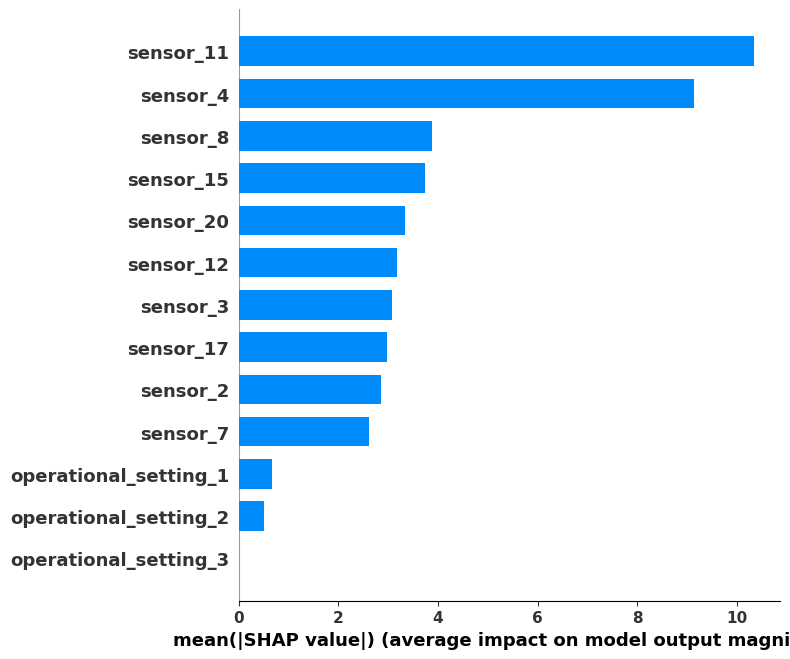

In [9]:
import shap

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_val_cmapss)

shap.summary_plot(shap_values, X_val_cmapss, plot_type="bar")

In [10]:
def fft_band_energy(signal, fs=25600, bands=[(0, 1000), (1000, 5000), (5000, 10000)]):
    N = len(signal)
    freqs = np.fft.fftfreq(N, d=1 / fs)
    fft_vals = np.abs(fft(signal)) ** 2
    energies = []
    for low, high in bands:
        mask = (freqs >= low) & (freqs < high)
        energies.append(np.sum(fft_vals[mask]) / N)
    return energies

def extract_features_from_file(file_path):
    df = pd.read_csv(file_path, header=None)
    df.columns = ['Hour', 'Minute', 'Second', 'Microsecond', 'Horiz_accel', 'Vert_accel']
    feats = {}
    for axis in ['Horiz_accel', 'Vert_accel']:
        signal = df[axis].values
        feats[f'RMS_{axis}'] = np.sqrt(np.mean(signal ** 2))
        feats[f'Kurtosis_{axis}'] = pd.Series(signal).kurt()
        feats[f'Skew_{axis}'] = skew(signal)
        feats[f'Entropy_{axis}'] = entropy(np.abs(signal) + 1e-10)
        feats[f'CrestFactor_{axis}'] = np.max(np.abs(signal)) / (np.sqrt(np.mean(signal ** 2)) + 1e-8)
        energies = fft_band_energy(signal)
        for i, e in enumerate(energies):
            feats[f'FFTband{i + 1}_{axis}'] = e
    return feats

In [11]:
# Example usage on one file
pronostia_dir = "../data/raw/PRONOSTIA/Learning_set/Bearing1_1/"
acc_file = os.path.join(pronostia_dir, "acc_00001.csv")
df_acc = pd.read_csv(acc_file, header=None)
df_acc.columns = ['Hour', 'Minute', 'Second', 'Microsecond', 'Horiz_accel', 'Vert_accel']

print('Shape:', df_acc.shape)
print(df_acc.head())

features_example = extract_features_from_file(acc_file)
print('Features from acc_00001.csv:', features_example)

Shape: (2560, 6)
   Hour  Minute  Second  Microsecond  Horiz_accel  Vert_accel
0     9      39      39      65664.0        0.552      -0.146
1     9      39      39      65703.0        0.501      -0.480
2     9      39      39      65742.0        0.138       0.435
3     9      39      39      65781.0       -0.423       0.240
4     9      39      39      65820.0       -0.802       0.020
Features from acc_00001.csv: {'RMS_Horiz_accel': 0.56174565773522, 'Kurtosis_Horiz_accel': -0.12937474006868177, 'Skew_Horiz_accel': -0.00471106707861808, 'Entropy_Horiz_accel': 7.57022023674449, 'CrestFactor_Horiz_accel': 3.578131733714442, 'FFTband1_Horiz_accel': 14.485748021246781, 'FFTband2_Horiz_accel': 339.5130212588877, 'FFTband3_Horiz_accel': 44.87625019917607, 'RMS_Vert_accel': 0.4358014232064301, 'Kurtosis_Vert_accel': -0.03280164198939506, 'Skew_Vert_accel': 0.002713478645300573, 'Entropy_Vert_accel': 7.567291891876442, 'CrestFactor_Vert_accel': 3.650745221956111, 'FFTband1_Vert_accel': 3.0488

In [12]:
# Process all PRONOSTIA bearing folders
base_dir = "../data/raw/PRONOSTIA/Learning_set/"
out_dir = "../data/processed/"
os.makedirs(out_dir, exist_ok=True)

all_records = []
for bearing_folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, bearing_folder)
    if os.path.isdir(folder_path):
        features_list = []
        files = sorted([f for f in os.listdir(folder_path) if f.startswith('acc_') and f.endswith('.csv')])
        label_threshold = int(0.9 * len(files))  # Heuristic: last 10% as failing
        for file in files:
            file_path = os.path.join(folder_path, file)
            feats = extract_features_from_file(file_path)
            feats['file'] = file
            feats['bearing_id'] = bearing_folder
            feats['label'] = 1 if files.index(file) >= label_threshold else 0
            features_list.append(feats)
        features_df_bearing = pd.DataFrame(features_list)
        features_df_bearing.to_csv(os.path.join(out_dir, f'{bearing_folder}.csv'), index=False)
        all_records.append(features_df_bearing)

features_df = pd.concat(all_records, ignore_index=True)

print('Bearings included:', features_df['bearing_id'].unique())
print('Shape:', features_df.shape)
print(features_df.head())

Bearings included: ['Bearing1_1' 'Bearing1_2' 'Bearing2_1' 'Bearing2_2' 'Bearing3_1'
 'Bearing3_2']
Shape: (7534, 19)
   RMS_Horiz_accel  Kurtosis_Horiz_accel  Skew_Horiz_accel  \
0         0.561746             -0.129375         -0.004711   
1         0.535112             -0.082464         -0.025791   
2         0.531158              0.035801         -0.005016   
3         0.554833              0.045851         -0.080165   
4         0.566652             -0.183492         -0.034187   

   Entropy_Horiz_accel  CrestFactor_Horiz_accel  FFTband1_Horiz_accel  \
0             7.570220                 3.578132             14.485748   
1             7.568644                 3.578687             15.607893   
2             7.557264                 3.578971             12.408148   
3             7.553766                 3.442476             15.040428   
4             7.566496                 3.118317             21.780992   

   FFTband2_Horiz_accel  FFTband3_Horiz_accel  RMS_Vert_accel  \
0    

In [13]:
X_pronostia = features_df.drop(columns=['file', 'label', 'bearing_id'])
y_pronostia = features_df['label']
groups_pronostia = features_df['bearing_id']

gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X_pronostia, y_pronostia, groups_pronostia))

X_train_pronostia, X_val_pronostia = X_pronostia.iloc[train_idx], X_pronostia.iloc[val_idx]
y_train_pronostia, y_val_pronostia = y_pronostia.iloc[train_idx], y_pronostia.iloc[val_idx]

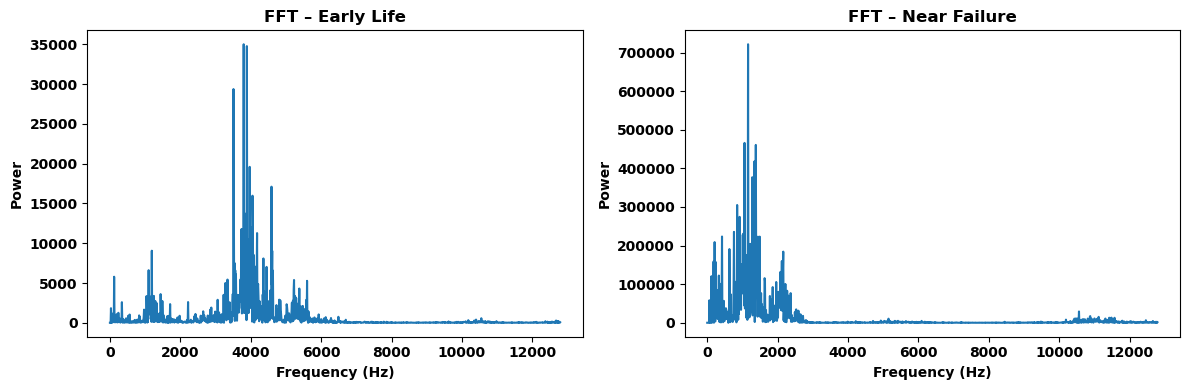

In [21]:
from scipy.fft import fft, fftfreq

# Early snapshot
early_file = "../data/raw/PRONOSTIA/Learning_set/Bearing1_1/acc_00010.csv"
late_file  = "../data/raw/PRONOSTIA/Learning_set/Bearing1_1/acc_02750.csv"

def plot_fft(file_path, title):
    df = pd.read_csv(file_path, header=None)
    df.columns = ["Hour","Minute","Second","Microsecond","Horiz_accel","Vert_accel"]
    signal = df['Horiz_accel'].values
    N = len(signal)
    N = len(signal)
    fs = 25600
    freqs = fftfreq(N, d=1/fs)
    fft_vals = np.abs(fft(signal))**2
    
    plt.plot(freqs[:N//2], fft_vals[:N//2])
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plot_fft(early_file, "FFT – Early Life")
plt.subplot(1,2,2)
plot_fft(late_file, "FFT – Near Failure")
plt.tight_layout()
plt.show()

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb_clf = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42)
xgb_clf.fit(X_train_pronostia, y_train_pronostia)

y_pred = xgb_clf.predict(X_val_pronostia)
print("PRONOSTIA XGBoost Classifier")
print(classification_report(y_val_pronostia, y_pred))

PRONOSTIA XGBoost Classifier
              precision    recall  f1-score   support

           0       1.00      0.76      0.86      3305
           1       0.31      0.99      0.47       369

    accuracy                           0.78      3674
   macro avg       0.66      0.87      0.67      3674
weighted avg       0.93      0.78      0.82      3674



In [15]:
from sklearn.svm import OneClassSVM

X_healthy = features_df[features_df['label']==0].drop(columns=['file','label', 'bearing_id'])
X_fail    = features_df[features_df['label']==1].drop(columns=['file','label', 'bearing_id'])

oc_svm = OneClassSVM(kernel="rbf", gamma="scale", nu=0.05)
oc_svm.fit(X_healthy)

# Correct version
y_pred_oc = oc_svm.predict(X_val_pronostia)   # -1 = anomaly
y_pred_oc = (y_pred_oc == -1).astype(int)  # convert -1 → 1 (failure)

print("PRONOSTIA One-Class SVM")
print(classification_report(y_val_pronostia, y_pred_oc))

PRONOSTIA One-Class SVM
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      3305
           1       0.54      0.89      0.67       369

    accuracy                           0.91      3674
   macro avg       0.76      0.90      0.81      3674
weighted avg       0.94      0.91      0.92      3674



In [22]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(max_iter=5000, solver='lbfgs'))
])

pipe.fit(X_train_pronostia, y_train_pronostia)
y_pred = pipe.predict(X_val_pronostia)
print(classification_report(y_val_pronostia, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.49      0.65      3305
           1       0.18      0.98      0.30       369

    accuracy                           0.54      3674
   macro avg       0.59      0.74      0.48      3674
weighted avg       0.91      0.54      0.62      3674



In [23]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_pronostia, y_train_pronostia)
y_pred_rf = rf_clf.predict(X_val_pronostia)
print('PRONOSTIA Random Forest (Grouped Split)')
print(classification_report(y_val_pronostia, y_pred_rf))

PRONOSTIA Random Forest (Grouped Split)
              precision    recall  f1-score   support

           0       1.00      0.65      0.79      3305
           1       0.24      0.99      0.39       369

    accuracy                           0.69      3674
   macro avg       0.62      0.82      0.59      3674
weighted avg       0.92      0.69      0.75      3674



In [24]:
from sklearn.ensemble import IsolationForest

X_healthy = X_train_pronostia[y_train_pronostia == 0]

iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_healthy)
y_pred_iso = iso_forest.predict(X_val_pronostia)
y_pred_iso = (y_pred_iso == -1).astype(int)
print('Isolation Forest')
print(classification_report(y_val_pronostia, y_pred_iso))

Isolation Forest
              precision    recall  f1-score   support

           0       1.00      0.48      0.65      3305
           1       0.17      0.98      0.30       369

    accuracy                           0.53      3674
   macro avg       0.58      0.73      0.47      3674
weighted avg       0.91      0.53      0.61      3674



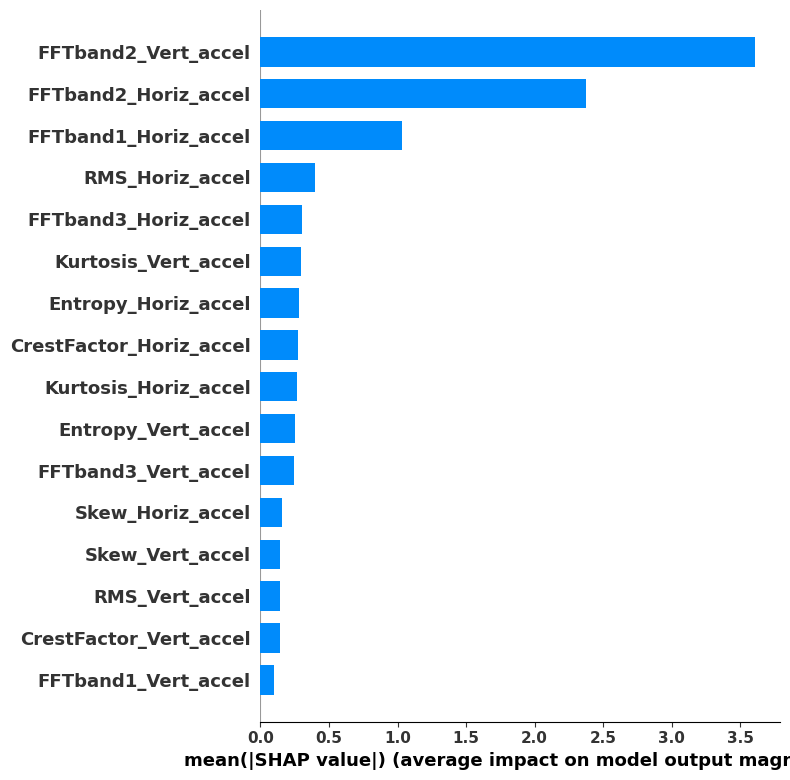

In [16]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_val_pronostia)

shap.summary_plot(shap_values, X_val_pronostia, plot_type="bar")

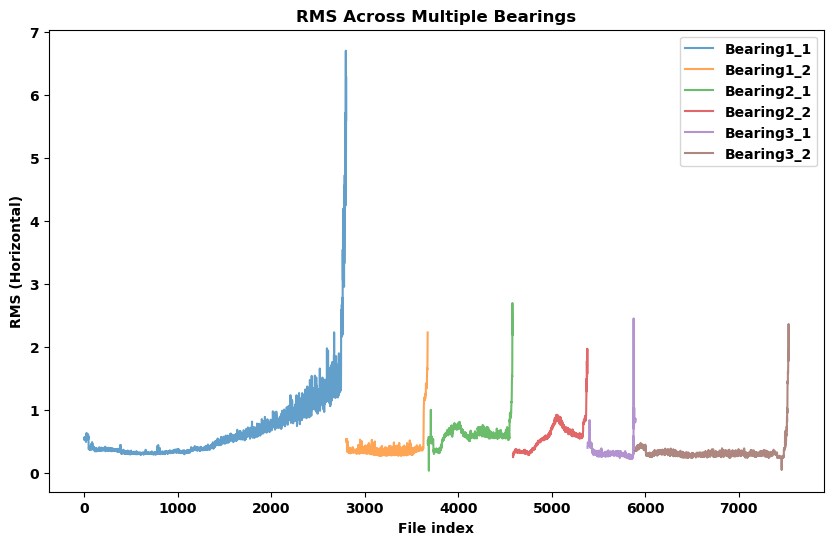

In [17]:
plt.figure(figsize=(10,6))
for bid in features_df["bearing_id"].unique():
    df_b = features_df[features_df["bearing_id"]==bid]
    plt.plot(df_b.index, df_b["RMS_Horiz_accel"], label=bid, alpha=0.7)
plt.legend()
plt.title("RMS Across Multiple Bearings")
plt.xlabel("File index")
plt.ylabel("RMS (Horizontal)")
plt.show()

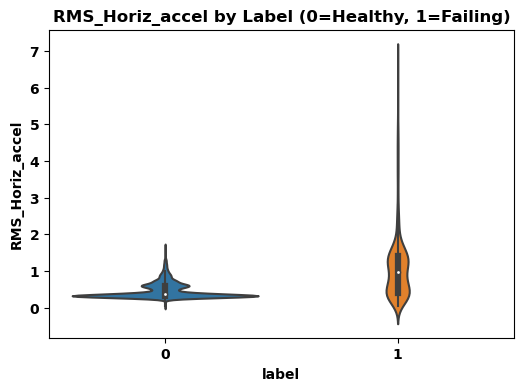

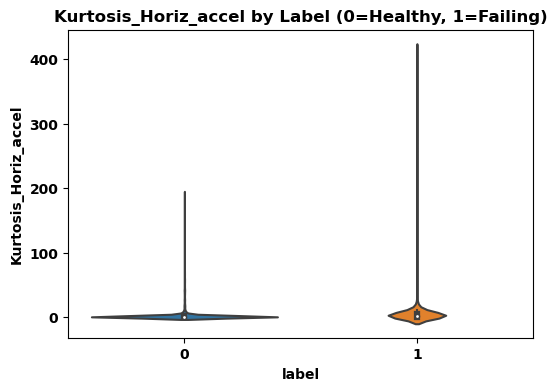

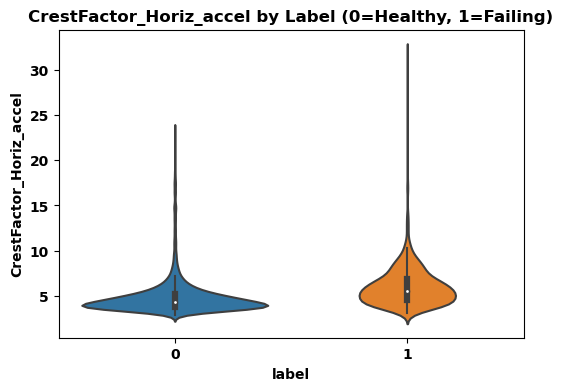

In [18]:
for feat in ["RMS_Horiz_accel","Kurtosis_Horiz_accel","CrestFactor_Horiz_accel"]:
    plt.figure(figsize=(6,4))
    sns.violinplot(data=features_df, x="label", y=feat)
    plt.title(f"{feat} by Label (0=Healthy, 1=Failing)")
    plt.show()

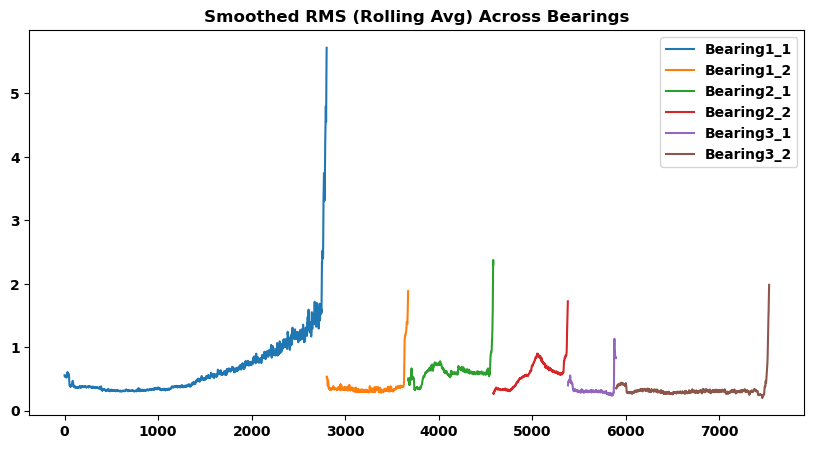

In [19]:
features_df_sorted = features_df.sort_values(by=["bearing_id","file"])
features_df_sorted["RMS_Horiz_accel_smooth"] = features_df_sorted.groupby("bearing_id")["RMS_Horiz_accel"].transform(lambda x: x.rolling(5, min_periods=1).mean())

plt.figure(figsize=(10,5))
for bid in features_df["bearing_id"].unique():
    df_b = features_df_sorted[features_df_sorted["bearing_id"]==bid]
    plt.plot(df_b.index, df_b["RMS_Horiz_accel_smooth"], label=f"{bid}")
plt.legend()
plt.title("Smoothed RMS (Rolling Avg) Across Bearings")
plt.show()

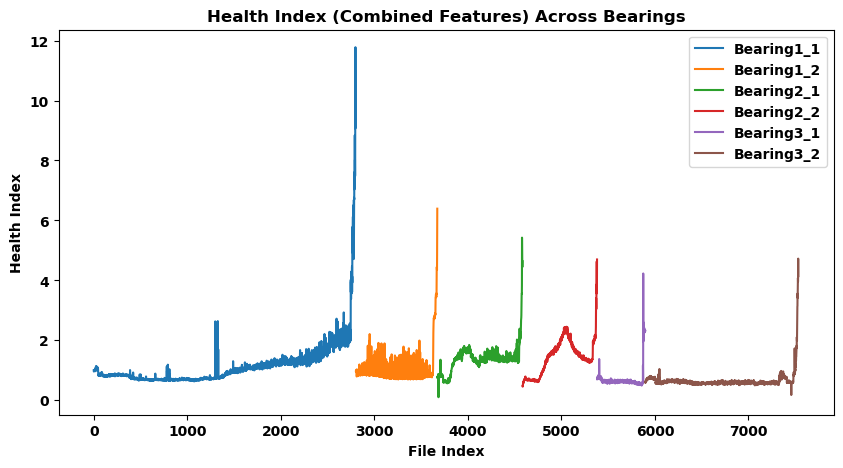

In [20]:
# Example: weighted sum of RMS + high-frequency band energy
features_df["health_index"] = (
    features_df["RMS_Horiz_accel"] +
    features_df["FFTband3_Horiz_accel"]*0.0001 + 
    features_df["RMS_Vert_accel"]
)

plt.figure(figsize=(10,5))
for bid in features_df["bearing_id"].unique():
    df_b = features_df[features_df["bearing_id"]==bid]
    plt.plot(df_b.index, df_b["health_index"], label=bid)
plt.legend()
plt.title("Health Index (Combined Features) Across Bearings")
plt.xlabel("File Index")
plt.ylabel("Health Index")
plt.show()